## Python code to check the astrometric matches recorded in icMatch / icSrc catalogs

In [31]:
import lsst.daf.persistence as dafPersist
from lsst.meas.astrom import Astrometry
import lsst.afw.cameraGeom as cg
import lsst.afw.geom as afwGeom
import math

# Image identification keys
visit = 849375
ccd = 14
filter = 'r'

ccdName = 'ccd'+str(ccd).zfill(2)

def angDist(ra_1, dec_1, ra_2, dec_2) :
# Compute separation angle between 2 positions in the sky given by their (ra,dec)
    sindec_1 = math.sin(dec_1)
    cosdec_1 = math.cos(dec_1)
    sindec_2 = math.sin(dec_2)
    cosdec_2 = math.cos(dec_2)
    cosra_2_ra_1 = math.cos(ra_2-ra_1)
    sinra_2_ra_1 = math.sin(ra_2-ra_1)
    
    aux = (cosdec_1 * sindec_2) - (sindec_1 * cosdec_2 * cosra_2_ra_1)
    num = (cosdec_2 * cosdec_2 * sinra_2_ra_1 * sinra_2_ra_1) + aux*aux
    den = (sindec_1 * sindec_2) + (cosdec_1 * cosdec_2 * cosra_2_ra_1)
    
    return math.atan2(math.sqrt(num), den)

#setup astrometry solver
solve = Astrometry.ConfigClass()
astrom = Astrometry(solve)

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output")
dataid = {'visit':visit, 'filter':filter, 'ccd':ccd}

# setup camera
cam = butler.get('camera')
ccd = cam[ccdName]

# Retrieve calexp
calexp = butler.get('calexp', dataid)

# Find ccd center coordinates and use them to load the corresponding reference catalog
# from astrometry_net_data

detCenter = ccd.getCenter(cg.PIXELS).getPoint()
detCenterCoord = calexp.getWcs().pixelToSky(detCenter)
refCat = astrom.getReferenceSources(detCenterCoord.getLongitude(), detCenterCoord.getLatitude(), afwGeom.Angle(1., afwGeom.degrees), filter)

# Retrieve icSrc and icMatch catalogs
# ic stands for "image characterization"i.e. sources used to perform photometric and astrometric calibaration
# icMatch contains the match between icSrc sources and the reference catalog. Each row contains 3 numbers :
# distance, id in reference catalog, id of source in icSrc catalog
icSrc = butler.get('icSrc', dataid)
icMatch = butler.get('icMatch', dataid)

# Print out the icSrc table schema
schema = icSrc.getSchema()
print schema.getOrderedNames()
print

# Sort icSrc and reference catalogs, this is mandatory in order to retrieve a row in a catalog based on its id
icSrc.sort()
refCat.sort()

diff_from_distance = []
diff_from_ra_dec = []
diff_between_both = []

print("Found %d matched sources in icMatch"%(len(icMatch)))
print

for match in icMatch:
# retrieve reference and source tables corresponding to the match
    ref = refCat.find(match.get('first'))
    source = icSrc.find(match.get('second'))
    if source != None : 
        dist = match.get('distance')
# Compute angular distance from the source and reference (ra, dec) 
        ang = angDist(ref.getRa(), ref.getDec(), source.getRa(), source.getDec())
        print match.get('first'), match.get('second'), afwGeom.radToMas(dist), afwGeom.radToMas(ang)
        
# Store results in list in order to check whether the angular distance computed 
# from the source and reference coordinates is matching the distance parameter recorded in icMatch
        diff_from_distance.append(afwGeom.radToMas(dist))
        diff_from_ra_dec.append(afwGeom.radToMas(ang))
        diff_between_both.append(afwGeom.radToMas(dist)-afwGeom.radToMas(ang))
    else :
        print match.get('second'), "not found !"

('id', 'coord', 'parent', 'flags_negative', 'initial_base_GaussianCentroid_x', 'initial_base_GaussianCentroid_y', 'initial_base_GaussianCentroid_flag', 'initial_base_GaussianCentroid_flag_noPeak', 'initial_base_NaiveCentroid_x', 'initial_base_NaiveCentroid_y', 'initial_base_NaiveCentroid_flag', 'initial_base_NaiveCentroid_flag_noCounts', 'initial_base_NaiveCentroid_flag_edge', 'initial_base_PixelFlags_flag', 'initial_base_PixelFlags_flag_edge', 'initial_base_PixelFlags_flag_interpolated', 'initial_base_PixelFlags_flag_interpolatedCenter', 'initial_base_PixelFlags_flag_saturated', 'initial_base_PixelFlags_flag_saturatedCenter', 'initial_base_PixelFlags_flag_cr', 'initial_base_PixelFlags_flag_crCenter', 'initial_base_PixelFlags_flag_bad', 'initial_base_SdssCentroid_x', 'initial_base_SdssCentroid_y', 'initial_base_SdssCentroid_xSigma', 'initial_base_SdssCentroid_ySigma', 'initial_base_SdssCentroid_x_y_Cov', 'initial_base_SdssCentroid_flag', 'initial_base_SdssCentroid_flag_edge', 'initial_

## Plot results and print Astrometric scatter

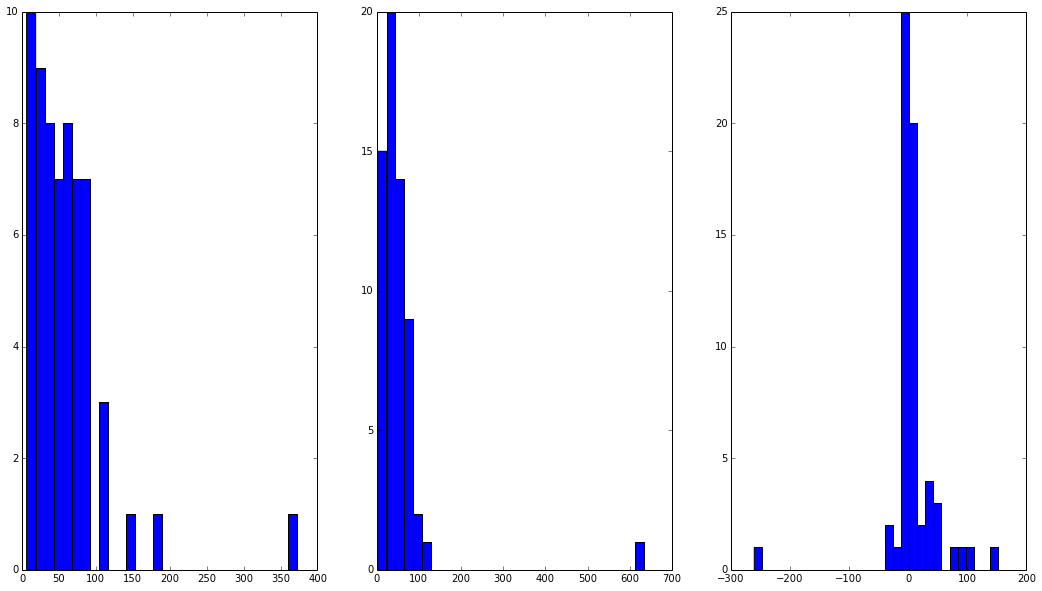

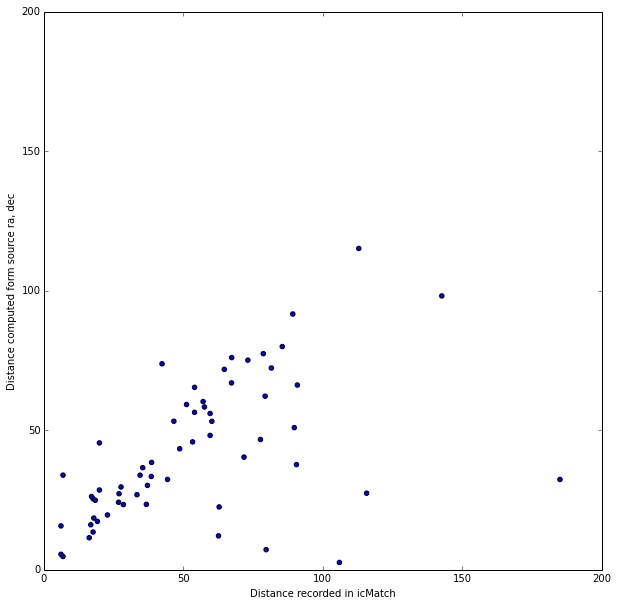

Number of sources kept 59 61
Astrometric scatter (median) from distance 52.2396802327 48.6947462053
Astrometric scatter (median) from ra, dec 37.1446597884 36.5909763433


In [32]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between icSrc and reference sources
plt.clf()
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18, 10))
ax0.hist(diff_from_distance,bins=30)
ax1.hist(diff_from_ra_dec,bins=30)
ax2.hist(diff_between_both,bins=30)
plt.show()

plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10, 10))
ax0.scatter(diff_from_distance,diff_from_ra_dec)
ax0.set_xlim([0.,200.])
ax0.set_ylim([0.,200.])
ax0.set_xlabel("Distance recorded in icMatch")
ax0.set_ylabel("Distance computed form source ra, dec")
plt.show()

# Compute median value of the distance

# select distances < 150 miliarcsec
idxs = np.where(np.asarray(diff_from_distance) < 130)
idxs2 = np.where(np.asarray(diff_from_ra_dec) < 130)
print "Number of sources kept", len(idxs[0]), len(idxs2[0])
print "Astrometric scatter (median) from distance", np.median(diff_from_distance), np.median(np.asarray(diff_from_distance)[idxs])
print "Astrometric scatter (median) from ra, dec", np.median(diff_from_ra_dec), np.median(np.asarray(diff_from_ra_dec)[idxs2])

## Conclusions

# Compute astrometric scatter between individual exposures

### First with the "icSrc" source (used by the astrometry solver)

In [33]:
import lsst.daf.persistence as dafPersist
from lsst.meas.astrom import Astrometry
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import math

def angDist(ra_1, dec_1, ra_2, dec_2) :
# Compute separation angle between 2 positions in the sky given by their (ra,dec)
    sindec_1 = math.sin(dec_1)
    cosdec_1 = math.cos(dec_1)
    sindec_2 = math.sin(dec_2)
    cosdec_2 = math.cos(dec_2)
    cosra_2_ra_1 = math.cos(ra_2-ra_1)
    sinra_2_ra_1 = math.sin(ra_2-ra_1)
    
    aux = (cosdec_1 * sindec_2) - (sindec_1 * cosdec_2 * cosra_2_ra_1)
    num = (cosdec_2 * cosdec_2 * sinra_2_ra_1 * sinra_2_ra_1) + aux*aux
    den = (sindec_1 * sindec_2) + (cosdec_1 * cosdec_2 * cosra_2_ra_1)
    
    return math.atan2(math.sqrt(num), den)

# List of visits to be considered
visits = [849375, 850587, 907254, 995367, 996234, 850181, 906675, 912206, 995974, 996717]

# Reference visit
ref = 849375

ccd = 12
filter = 'r'

Flags = ["initial_base_PixelFlags_flag_saturated", "initial_base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "initial_base_PsfFlux_flag_edge"]

ccdName = 'ccd'+str(ccd).zfill(2)

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output")

dataid = {'visit':ref, 'filter':filter, 'ccd':ccd}
srcRef = butler.get('icSrc', dataid)
md = butler.get("calexp_md", dataid, immediate=True)
calib = afwImage.Calib(md)

#print srcRef.getSchema().getOrderedNames()

mag = []
dist = []
for v in visits :
    if v == ref :
        continue
    dataid = {'visit':v, 'filter':filter, 'ccd':ccd}
    srcVis = butler.get('icSrc', dataid)
    
    match = afwTable.matchRaDec(srcRef, srcVis, afwGeom.Angle(1./3600., afwGeom.degrees))
    print "Visit :", v, len(match), "matches found"
    
    for m in match :
        mRef = m.first
        mVis = m.second
        
        for f in Flags :
            if mRef.get(f) or mVis.get(f) :
                continue
        
        if mRef.get("base_ClassificationExtendedness_value") >= 1.0 or mVis.get("base_ClassificationExtendedness_value") >= 1.0 :
            continue
        
        ang = afwGeom.radToMas(m.distance)
        refMag = calib.getMagnitude(mRef.get('base_PsfFlux_flux'))
                                    
        mag.append(refMag)
        dist.append(ang)
        

Visit : 850587 107 matches found
Visit : 907254 121 matches found
Visit : 995367 101 matches found
Visit : 996234 92 matches found
Visit : 850181 91 matches found
Visit : 906675 90 matches found
Visit : 912206 94 matches found
Visit : 995974 106 matches found
Visit : 996717 51 matches found


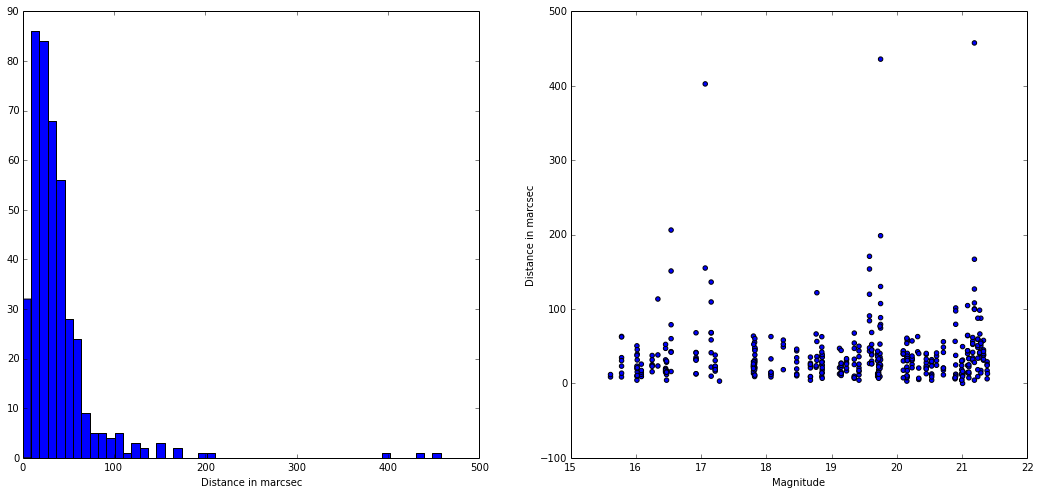

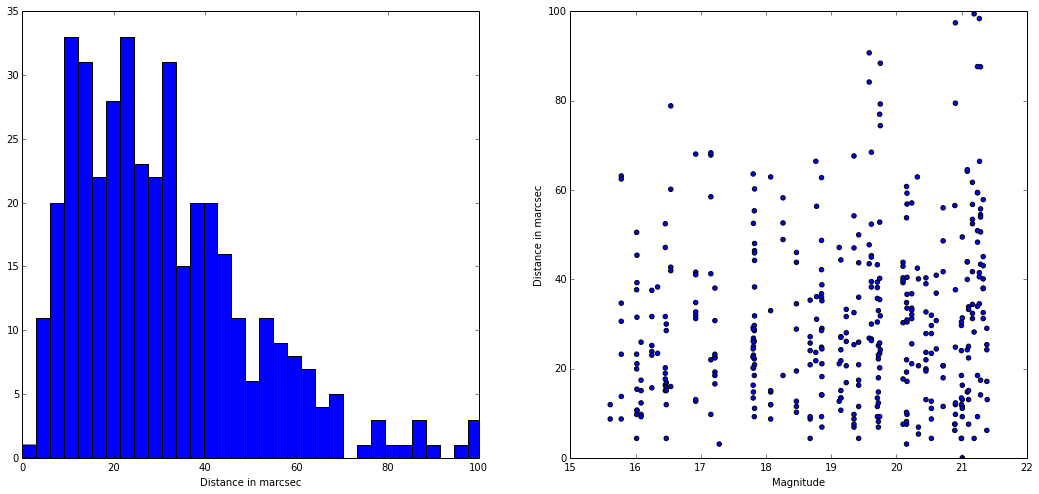

Median value of the astrometric scatter : 28.832784233 marcsec


In [34]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(dist,bins=50)
ax1.scatter(mag, dist)
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
plt.show()

plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(dist,bins=150)
ax0.set_xlim([0.,100.])
ax1.scatter(mag, dist)
ax1.set_ylim([0.,100.])
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
plt.show()

print "Median value of the astrometric scatter :", np.median(dist), "marcsec"

### And second using the "src" sources

In [29]:
import lsst.daf.persistence as dafPersist
from lsst.meas.astrom import Astrometry
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import math

def angDist(ra_1, dec_1, ra_2, dec_2) :
# Compute separation angle between 2 positions in the sky given by their (ra,dec)
    sindec_1 = math.sin(dec_1)
    cosdec_1 = math.cos(dec_1)
    sindec_2 = math.sin(dec_2)
    cosdec_2 = math.cos(dec_2)
    cosra_2_ra_1 = math.cos(ra_2-ra_1)
    sinra_2_ra_1 = math.sin(ra_2-ra_1)
    
    aux = (cosdec_1 * sindec_2) - (sindec_1 * cosdec_2 * cosra_2_ra_1)
    num = (cosdec_2 * cosdec_2 * sinra_2_ra_1 * sinra_2_ra_1) + aux*aux
    den = (sindec_1 * sindec_2) + (cosdec_1 * cosdec_2 * cosra_2_ra_1)
    
    return math.atan2(math.sqrt(num), den)

# List of visits to be considered
visits = [849375, 850587, 907254, 995367, 996234, 850181, 906675, 912206, 995974, 996717]
# visits = [849375, 850587]

# Reference visit
ref = 849375

# List of CCD to be considered (source calatlogs will be concateneted)
ccd = [12, 13, 14, 21, 22, 23]
#ccd = [12, 13]

filter = 'r'

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge"]

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output")

for indx, c in enumerate(ccd) :
    dataid = {'visit':ref, 'filter':filter, 'ccd':c}
    oldSrc = butler.get('src', dataid, immediate=True)
    print c, len(oldSrc)
    if indx == 0 :
        # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
        oldSchema = oldSrc.getSchema()
        mapper = afwTable.SchemaMapper(oldSchema)
        mapper.addMinimalSchema(oldSchema)
        newSchema = mapper.getOutputSchema()
        newSchema.addField("ccd", type=int, doc="CCD number")
        
        #create the new extented source catalog 
        srcRef = afwTable.SourceCatalog(newSchema)
    
    # create temporary catalog
    tmpCat = afwTable.SourceCatalog(srcRef.table)
    tmpCat.extend(oldSrc, mapper=mapper)
    # fill in the ccd information in numpy mode in order to be efficient
    tmpCat['ccd'][:] = c
    # append the temporary catalog to the extended source catalog    
    srcRef.extend(tmpCat, deep=False)

print "Ref...", len(srcRef)

mag = []
dist = []
for v in visits :
    if v == ref :
        continue
    for indx, c in enumerate(ccd) :
        dataid = {'visit':v, 'filter':filter, 'ccd':c}
        if indx == 0 :
            srcVis = butler.get('src', dataid, immediate=True)
        else :
            srcVis.extend(butler.get('src', dataid, immediate=True), False)
        print c, len(srcVis)
    
    match = afwTable.matchRaDec(srcRef, srcVis, afwGeom.Angle(1./3600., afwGeom.degrees))
    print "Visit :", v, len(match), "matches found"
    
    for m in match :
        mRef = m.first
        mVis = m.second
        
        for f in Flags :
            if mRef.get(f) or mVis.get(f) :
                continue
        
        # claenup the reference sources in order keep decent star-like objects
        if mRef.get("base_ClassificationExtendedness_value") >= 1.0 or mVis.get("base_ClassificationExtendedness_value") >= 1.0 :
            continue
        
        ang = afwGeom.radToMas(m.distance)
        
        # retrieve the CCD corresponding to the reference source
        ccdRef = mRef.get('ccd')
        # retrieve the calibration object associated to the CCD
        did = {'visit':ref, 'filter':filter, 'ccd':ccdRef}
        md = butler.get("calexp_md", did, immediate=True)
        calib = afwImage.Calib(md)
        # compute magnitude
        refMag = calib.getMagnitude(mRef.get('base_PsfFlux_flux'))
                                    
        mag.append(refMag)
        dist.append(ang)

12 1067
13 1081
14 1047
21 1102
22 1108
23 1118
Ref... 6523
12 1597
13 3276
14 5026
21 6740
22 8545
23 10356
Visit : 850587 5640 matches found
12 1539
13 3149
14 4734
21 6304
22 7911
23 9613
Visit : 907254 6077 matches found
12 2642
13 5512
14 8415
21 11430
22 14685
23 17785
Visit : 995367 5601 matches found
12 1206
13 2583
14 3988
21 5476
22 7041
23 8588
Visit : 996234 5099 matches found
12 1684
13 3452
14 5239
21 7040
22 8922
23 10798
Visit : 850181 5278 matches found
12 1742
13 3521
14 5347
21 7178
22 9068
23 11014
Visit : 906675 5237 matches found
12 1657
13 3371
14 5111
21 6856
22 8667
23 10480
Visit : 912206 5303 matches found
12 1123
13 2438
14 3799
21 5222
22 6603
23 8128
Visit : 995974 5125 matches found
12 781
13 1752
14 2690
21 3675
22 4767
23 5850
Visit : 996717 4397 matches found


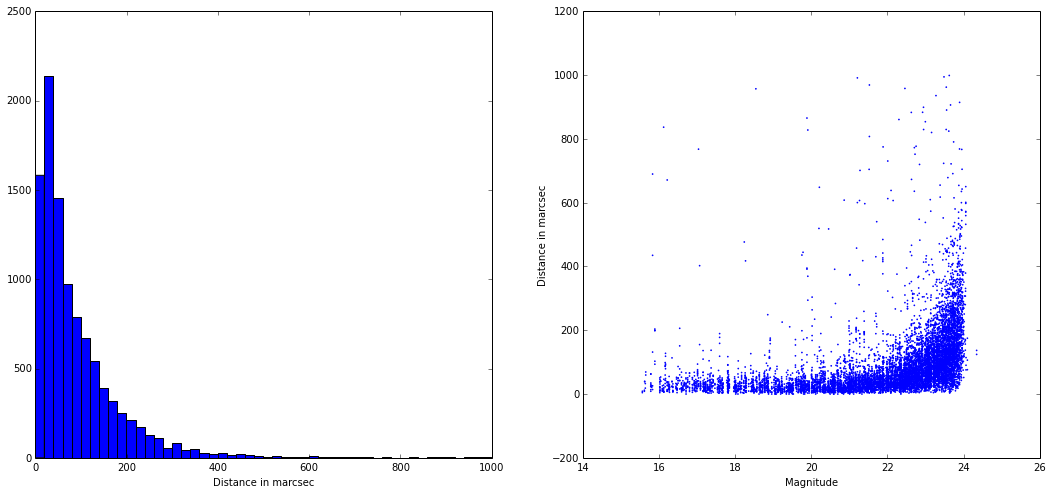

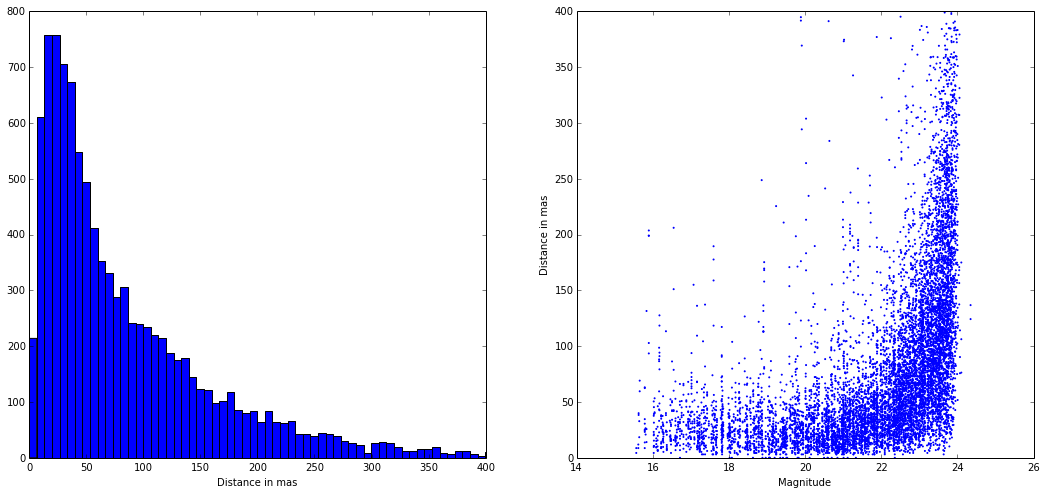

Median value of the astrometric scatter : 58.6402668213 mas


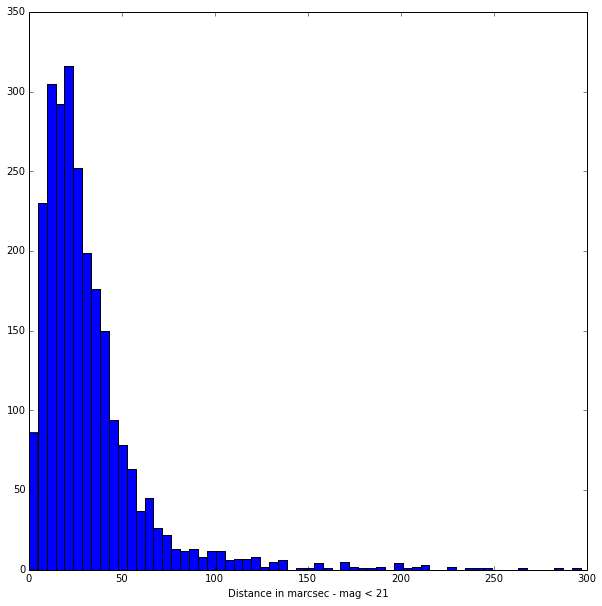

Astrometric scatter (median) - mag < 21 : 24.588681012 mas


In [30]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(dist, bins=50)
ax1.scatter(mag, dist, s=0.5, color='b')
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
plt.show()

plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(dist,bins=150)
ax0.set_xlim([0.,400.])
ax1.scatter(mag, dist, s=1, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")
plt.show()

print "Median value of the astrometric scatter :", np.median(dist), "mas"

idxs = np.where(np.asarray(mag) < 21)
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(dist)[idxs], bins=200)
ax0.set_xlabel("Distance in marcsec - mag < 21")
ax0.set_xlim([0,300])
plt.show()

print "Astrometric scatter (median) - mag < 21 :", np.median(np.asarray(dist)[idxs]), "mas"